# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [51]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 2

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [52]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Standard Scaling
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train),dtype = torch.float32)
X_val = torch.tensor(scaler.transform(X_val),dtype = torch.float32)

print("Test class distribution is as follows: \n", pd.Series(y_val.flatten()).value_counts())


Test class distribution is as follows: 
 0.0    555
1.0    345
Name: count, dtype: int64


In [54]:
def init_weights(m,n):
  return (torch.randn(m, n) * torch.sqrt(torch.tensor(2.0 / m))).requires_grad_(True)

"""I have used He initialisation here to conserve the variance of output data after every single layer.
Without this, the output variance increases exponentially at each and every layer of our MLP.
The reason why this is unfavourable is because it leads to a very high input by the final layer which pushes us towards the saturation region
of our activation function, be it sigmoid or tanh. As such, our weights may stop updating at all. This is the problem of Vanishing Gradients.

Moreover, the relatively high number of neurons and layers results in a situation where non-normalised weights can explode the error function.
This happens when our loss function and gradients overflow into infinity, which PyTorch perceives as NaN during weight updates."""

'I have used He initialisation here to conserve the variance of output data after every single layer.\nWithout this, the output variance increases exponentially at each and every layer of our MLP. \nThe reason why this is unfavourable is because it leads to a very high input by the final layer which pushes us towards the saturation region\nof our activation function, be it sigmoid or tanh. As such, our weights may stop updating at all. This is the problem of Vanishing Gradients.\n\nMoreover, the relatively high number of neurons and layers results in a situation where non-normalised weights can explode the error function.\nThis happens when our loss function and gradients overflow into infinity, which PyTorch perceives as NaN during weight updates.'

In [55]:
# initialising initial weights and biases as per our prescribed architecture
torch.manual_seed(42)

# weights connecting input layer to Hidden Layer 1, with the corresponding 16 biases of the hidden layer.
w1 = init_weights(2,16)
b1 = torch.randn(16, requires_grad=True)

# weights and biases bridging Hidden Layer 1 to Hidden Layer 2
w2 = init_weights(16,16)
b2 = torch.randn(16, requires_grad=True)

# weights and biases bridging Hidden Layer 2 to Hidden Layer 3
w3 = init_weights(16,16)
b3 = torch.randn(16, requires_grad=True)

# weights and biases bridging the final Hidden Layer to output layer
w4 = init_weights(16,1)
b4 = torch.randn(1, requires_grad=True)

In [56]:
def forward_pass(X):
  z1 = torch.matmul(X, w1) + b1
  a1 = torch.relu(z1)

  z2 = torch.matmul(a1, w2) + b2
  a2 = torch.relu(z2)

  z3 = torch.matmul(a2, w3) + b3
  a3 = torch.relu(z3)

  z4 = torch.matmul(a3, w4) + b4
  a4 = torch.sigmoid(z4)

  return a4

In [57]:
learning_rate = 0.1
epochs = 1000
train_losses, val_losses = [],[]
train_accs, val_accs = [],[]

for epoch in range(epochs):

  # Forward Pass
  pred_train = forward_pass(X_train)
  loss = -(y_train * torch.log(pred_train + 1e-12) + (1 - y_train) * torch.log(1 - pred_train + 1e-12)).mean()

  # Backward Pass
  loss.backward()
  with torch.no_grad():
    for param in [w1, b1, w2, b2, w3, b3, w4, b4]:
      param -= learning_rate * param.grad
      param.grad.zero_()

  with torch.no_grad():
      pred_val = forward_pass(X_val)
      val_loss = -(y_val * torch.log(pred_val + 1e-12) + (1 - y_val) * torch.log(1 - pred_val + 1e-12)).mean()

      train_accuracies = ((pred_train > 0.5) == y_train).float().mean()
      val_accuracies = ((pred_val > 0.5) == y_val).float().mean()

      train_losses.append(loss.item())
      val_losses.append(val_loss.item())
      train_accs.append(train_accuracies.item())
      val_accs.append(val_accuracies.item())


  if epoch % 100 == 0:
    print(f"Epoch: {epoch}, Loss: {loss.item():.4f} | Val Accuracy: {val_accuracies.item()*100:.2f}%")


Epoch: 0, Loss: 1.1696 | Val Accuracy: 39.22%
Epoch: 100, Loss: 0.5749 | Val Accuracy: 68.00%
Epoch: 200, Loss: 0.5115 | Val Accuracy: 73.22%
Epoch: 300, Loss: 0.4580 | Val Accuracy: 77.56%
Epoch: 400, Loss: 0.4234 | Val Accuracy: 82.56%
Epoch: 500, Loss: 0.3910 | Val Accuracy: 87.11%
Epoch: 600, Loss: 0.3612 | Val Accuracy: 88.22%
Epoch: 700, Loss: 0.3633 | Val Accuracy: 84.89%
Epoch: 800, Loss: 0.3454 | Val Accuracy: 86.11%
Epoch: 900, Loss: 0.3342 | Val Accuracy: 87.00%


The GDC Dashboard: a 3-panel HUD


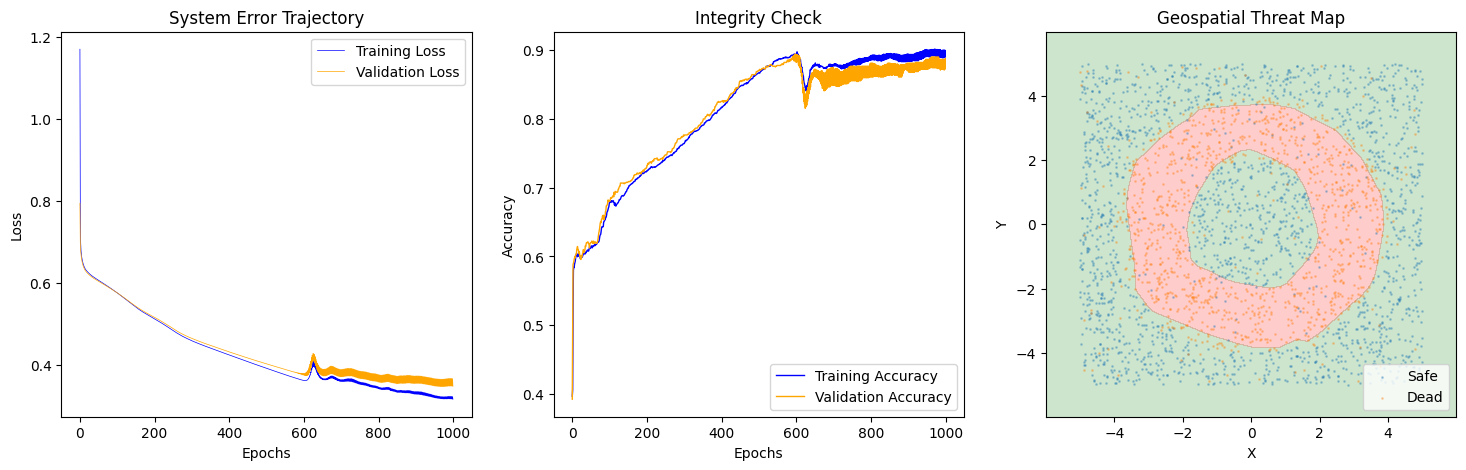

In [58]:
from matplotlib import pyplot as plt

print("The GDC Dashboard: a 3-panel HUD")
fig, ax = plt.subplots(1,3, figsize = (18,5))

# 1. System Error Trajectory: a Loss Plot

ax[0].plot(train_losses, label = "Training Loss",color = "blue", linewidth = 0.5)
ax[0].plot(val_losses, label = "Validation Loss", color = "orange", linewidth = 0.5)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("System Error Trajectory")
ax[0].legend()

# 2. Integrity Check: an Accuracy Plot

ax[1].plot(train_accs, label = "Training Accuracy",color = "blue", linewidth = 1)
ax[1].plot(val_accs, label = "Validation Accuracy", color = "orange", linewidth = 1)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Integrity Check")
ax[1].legend()

# 3. Geospatial Threat Map: the Decision Boundary

x_min, x_max = X_full[:, 0].min() - 1, X_full[:, 0].max() + 1
y_min, y_max = X_full[:, 1].min() - 1, X_full[:, 1].max() + 1
xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100), torch.linspace(y_min, y_max, 100))
grid_pts = torch.cat([xx.reshape(-1,1),yy.reshape(-1,1)],dim =1)

grid_pts_scaled = torch.tensor(scaler.transform(grid_pts),dtype = torch.float32)

with torch.no_grad():
  Z = forward_pass(grid_pts_scaled).reshape(xx.shape)

ax[2].contourf(xx, yy, Z, levels = [0,0.5,1], alpha=0.2, colors = ["green", "red"])
ax[2].scatter(X_full[y_full.flatten()==0,0], X_full[y_full.flatten()==0,1],s = 1, label = "Safe", alpha = 0.3)
ax[2].scatter(X_full[y_full.flatten()==1,0], X_full[y_full.flatten()==1,1],s = 1, label = "Dead", alpha = 0.3)
ax[2].set_xlabel("X")
ax[2].set_ylabel("Y")
ax[2].set_title("Geospatial Threat Map")
ax[2].legend()

plt.show()